In [1]:
# Standard Libraries
import argparse
import os
import sys
from tqdm import tqdm

# Python Modules
from collections import Counter
from dataclasses import dataclass
from typing import NamedTuple
from collections import namedtuple
import gc

# Type Hint Libraries
from typing import Optional, Tuple, Union, TypeVar, List
import numpy.typing as npt
import matplotlib.figure
from torch import Tensor

# Math and Data Science Libraries
import numpy as np
import pandas as pd
from scipy.ndimage.filters import convolve

# Plot Libraries
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton

# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader


# Image Libraries
import cv2

import skimage as ski
from skimage import io
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb

# User defined methods and classes
sys.path.insert(0,'/content/drive/MyDrive/')

<ipython-input-1-a738c95dbd0d>:23: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [2]:
from utils import parse_line
from utils import lines_to_polygons
from utils import build_mask_dataset
from utils import mask_in_set
from utils import nodes_to_points
from utils import plot_image_and_mask
from utils import create_binary_mask

from Unet_model import UNET

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# Path to dataset
DATA_PATH = '/content/drive/MyDrive/PNG/'
# Creating a path to save masks
MASKS_PATH = '/content/drive/MyDrive/masks/'
# Creating a path to save model
MODEL_PATH = '/content/drive/MyDrive/model/unet_weigths_v7.pth'

In [5]:
# Creates a list of the *.png file names in the dataset
image_files = os.listdir(DATA_PATH)

In [6]:
image_names = []

for file_name in image_files:
    image_names.append(file_name.replace('.png',''))

In [7]:
print(len(image_names))
image_names = image_names[:1351]

1705


In [8]:
train_image_names, test_image_names, _, _ = train_test_split(image_names, image_names, test_size=0.2, random_state=42)

In [9]:
train_images = []
test_images = []
train_masks = []
test_masks = []

In [10]:
# Loading train images as grayscale images
for name in train_image_names:
    full_path = DATA_PATH + name + '.png'
    curr_image = io.imread(full_path)
    train_images.append(rgb2gray(curr_image))

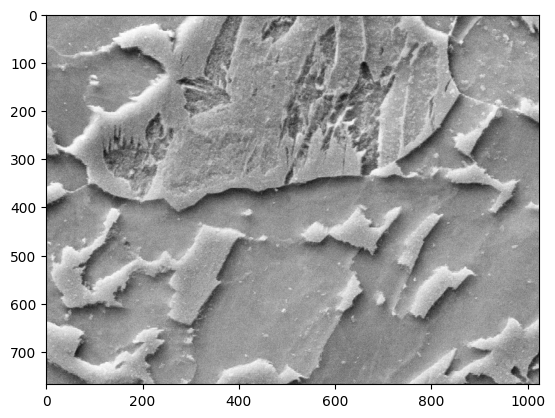

In [11]:
# Testing images were loaded correctly
plt.imshow(train_images[0], cmap=plt.cm.gray)
plt.show()

In [12]:
print('Image shape:         ',train_images[0].shape)
print('Element type:        ',train_images[0].dtype)
print('Data structure type: ',type(train_images[0]))
print('Max. value:          ',np.max(train_images[0]))
print('Min. value:          ',np.min(train_images[0]))
print('Length images:       ',len(train_images))

Image shape:          (768, 1024)
Element type:         float64
Data structure type:  <class 'numpy.ndarray'>
Max. value:           0.996078431372549
Min. value:           0.06666666666666667
Length images:        1080


In [13]:
# Loading train masks as grayscale images
for name in train_image_names:
    full_path = MASKS_PATH + name + '.jpg'
    curr_mask = io.imread(full_path)
    train_masks.append(rgb2gray(curr_mask).round())

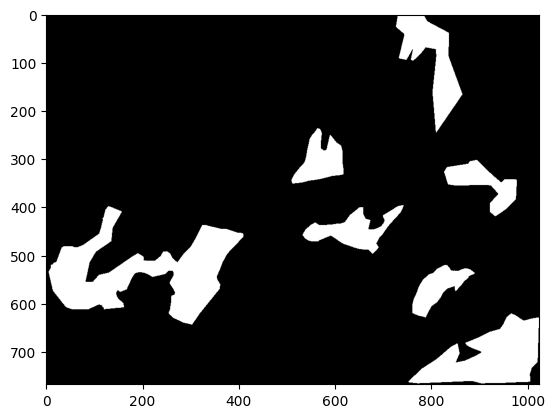

In [14]:
# Testing images were loaded correctly
plt.imshow(train_masks[0], cmap=plt.cm.gray)
plt.show()

In [15]:
print('Image shape:         ',train_masks[0].shape)
print('Element type:        ',train_masks[0].dtype)
print('Data structure type: ',type(train_masks[0]))
print('Max. value:          ',np.max(train_masks[0]))
print('Min. value:          ',np.min(train_masks[0]))
print('Length masks:        ',len(train_masks))

Image shape:          (768, 1024)
Element type:         float64
Data structure type:  <class 'numpy.ndarray'>
Max. value:           1.0
Min. value:           0.0
Length masks:         1080


In [16]:
# Loading test images as grayscale images
for name in test_image_names:
    full_path = DATA_PATH + name + '.png'
    curr_image = io.imread(full_path)
    test_images.append(rgb2gray(curr_image))

In [17]:
# Loading test images as grayscale images
for name in test_image_names:
    full_path = MASKS_PATH + name + '.jpg'
    curr_mask = io.imread(full_path)
    test_masks.append(rgb2gray(curr_mask).round())

First I created a custom Dataset class for this particular dataset:

In [18]:
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, images: list, masks: list):
        super(DataLoaderSegmentation, self).__init__()
        assert len(images) == len(masks), 'Length of image list must be the same of masks list'
        self.img = np.array(images)
        self.msk = np.array(masks)

    def __getitem__(self, index)->Tuple[Tensor]:
            data = self.img[index]
            label = self.msk[index]
            return torch.unsqueeze(torch.from_numpy(data).float(),0), torch.unsqueeze(torch.from_numpy(label).float(),0)

    def __len__(self):
        return len(self.img)

In [19]:
train_dataset = DataLoaderSegmentation(train_images,train_masks)
test_dataset = DataLoaderSegmentation(test_images,test_masks)

Next step is creating a dataloader for the network

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

Model

In [21]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4                                          # Paper uses lr=2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # Paper uses 20
NUM_EPOCHS = 3                                                # Paper uses 1e10 if
NUM_WORKERS = 2                                               # paper uses 0
IMAGE_HEIGHT = 768
IMAGE_WIDTH = 1024
PIN_MEMORY = True
LOAD_MODEL = False
loss_fn = torch.nn.BCEWithLogitsLoss()                        # Paper uses losses.DiceBCELoss(weight=0.7)
scaler = torch.cuda.amp.GradScaler()
model = UNET().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Paper uses Adam
# metrics = [smp.utils.metrics.IoU(threshold=0.5),]           # Coming from the paper

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    loop = tqdm(dataloader)

    loss_20_batches = 0
    loss_epoch = 0

    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    for batch, (image, mask) in enumerate(loop):

        image = image.to(DEVICE)
        mask = mask.to(DEVICE)

        with torch.cuda.amp.autocast(): # Mod
            # Compute prediction and loss
            pred = model(image)
            loss = loss_fn(pred, mask)
            loss_20_batches += loss
            loss_epoch += loss

        # Backpropagation Mod
        optimizer.zero_grad()         # Original 1: loss.backward()
        scaler.scale(loss.to(DEVICE)).backward() # Original 2: optimizer.step()
        scaler.step(optimizer)        # Original 3: optimizer.zero_grad()
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

        if batch % 20 == 0:
            loop.set_postfix(loss_20_batches=loss_20_batches.item()/20)
            loss_20_batches = 0

    print(f"==> training_loss: {loss_epoch/len(dataloader):2f}")

In [23]:
def test_loop(dataloader, model, loss_fn):

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    loss_epoch = 0

    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True

    with torch.no_grad():
        for batch, (image, mask) in enumerate(dataloader):

            image = image.to(DEVICE)
            mask = mask.to(DEVICE)

            pred = model(image)

            loss_epoch += loss_fn(pred, mask)
            mask_pred = torch.sigmoid(pred)
            mask_pred = (mask_pred > 0.5).float()

            num_correct += (mask_pred == mask).sum()
            num_pixels += torch.numel(mask_pred)
            dice_score += (2 * (mask_pred * mask).sum()) / (
                    (mask_pred + mask).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {(num_correct/num_pixels)*100:.2f}"
    )
    print(
        f"==> valuation_loss: {loss_epoch/len(dataloader):2f}"
    )

    print(f"==> dice_score: {dice_score/len(dataloader)}")

    model.train()

In [24]:
DEVICE

'cuda'

In [25]:
epochs = 250
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 68/68 [01:21<00:00,  1.20s/it, loss=0.348]


==> training_loss: 0.463955
Got 197886258/213123072 with acc 92.85
==> valuation_loss: 0.380066
==> dice_score: 0.0
Epoch 2
-------------------------------


100%|██████████| 68/68 [01:47<00:00,  1.57s/it, loss=0.38]


==> training_loss: 0.361676
Got 195765948/213123072 with acc 91.86
==> valuation_loss: 0.357592
==> dice_score: 0.2615017890930176
Epoch 3
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.309]


==> training_loss: 0.323900
Got 195455445/213123072 with acc 91.71
==> valuation_loss: 0.328286
==> dice_score: 0.39420777559280396
Epoch 4
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.266]


==> training_loss: 0.293997
Got 198545780/213123072 with acc 93.16
==> valuation_loss: 0.290117
==> dice_score: 0.4501885771751404
Epoch 5
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.254]


==> training_loss: 0.269951
Got 198826778/213123072 with acc 93.29
==> valuation_loss: 0.261031
==> dice_score: 0.409061998128891
Epoch 6
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.25]


==> training_loss: 0.251294
Got 200014650/213123072 with acc 93.85
==> valuation_loss: 0.247179
==> dice_score: 0.4260800778865814
Epoch 7
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.218]


==> training_loss: 0.233851
Got 198265576/213123072 with acc 93.03
==> valuation_loss: 0.252844
==> dice_score: 0.4536072909832001
Epoch 8
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.2]


==> training_loss: 0.219259
Got 199885268/213123072 with acc 93.79
==> valuation_loss: 0.216945
==> dice_score: 0.5424050688743591
Epoch 9
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.211]


==> training_loss: 0.209202
Got 200399154/213123072 with acc 94.03
==> valuation_loss: 0.206937
==> dice_score: 0.5147498250007629
Epoch 10
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.261]


==> training_loss: 0.198558
Got 201112481/213123072 with acc 94.36
==> valuation_loss: 0.193562
==> dice_score: 0.5274819731712341
Epoch 11
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.195]


==> training_loss: 0.190257
Got 200924817/213123072 with acc 94.28
==> valuation_loss: 0.187332
==> dice_score: 0.44433993101119995
Epoch 12
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.194]


==> training_loss: 0.181109
Got 201072898/213123072 with acc 94.35
==> valuation_loss: 0.177098
==> dice_score: 0.5787028074264526
Epoch 13
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.56s/it, loss=0.177]


==> training_loss: 0.175158
Got 200582297/213123072 with acc 94.12
==> valuation_loss: 0.200766
==> dice_score: 0.560072660446167
Epoch 14
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.196]


==> training_loss: 0.170119
Got 201283008/213123072 with acc 94.44
==> valuation_loss: 0.166836
==> dice_score: 0.5527320504188538
Epoch 15
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.148]


==> training_loss: 0.164847
Got 201080481/213123072 with acc 94.35
==> valuation_loss: 0.171470
==> dice_score: 0.5666908621788025
Epoch 16
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.161]


==> training_loss: 0.158046
Got 200686053/213123072 with acc 94.16
==> valuation_loss: 0.169467
==> dice_score: 0.497077614068985
Epoch 17
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.146]


==> training_loss: 0.153845
Got 200374791/213123072 with acc 94.02
==> valuation_loss: 0.164955
==> dice_score: 0.35806554555892944
Epoch 18
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.169]


==> training_loss: 0.149568
Got 201154207/213123072 with acc 94.38
==> valuation_loss: 0.162420
==> dice_score: 0.5211805105209351
Epoch 19
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.114]


==> training_loss: 0.146849
Got 201363240/213123072 with acc 94.48
==> valuation_loss: 0.154271
==> dice_score: 0.5581426024436951
Epoch 20
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.136]


==> training_loss: 0.140452
Got 200665844/213123072 with acc 94.15
==> valuation_loss: 0.152635
==> dice_score: 0.39190709590911865
Epoch 21
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.169]


==> training_loss: 0.138581
Got 201504496/213123072 with acc 94.55
==> valuation_loss: 0.148187
==> dice_score: 0.5472095608711243
Epoch 22
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.112]


==> training_loss: 0.137488
Got 201488210/213123072 with acc 94.54
==> valuation_loss: 0.145674
==> dice_score: 0.49749475717544556
Epoch 23
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.127]


==> training_loss: 0.133022
Got 199837817/213123072 with acc 93.77
==> valuation_loss: 0.152035
==> dice_score: 0.27194100618362427
Epoch 24
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.132]


==> training_loss: 0.130311
Got 199929468/213123072 with acc 93.81
==> valuation_loss: 0.159527
==> dice_score: 0.5976688265800476
Epoch 25
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.125]


==> training_loss: 0.126727
Got 201096035/213123072 with acc 94.36
==> valuation_loss: 0.147100
==> dice_score: 0.5952816009521484
Epoch 26
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.116]


==> training_loss: 0.125764
Got 200654380/213123072 with acc 94.15
==> valuation_loss: 0.149689
==> dice_score: 0.401502788066864
Epoch 27
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0981]


==> training_loss: 0.119280
Got 201107220/213123072 with acc 94.36
==> valuation_loss: 0.145974
==> dice_score: 0.552517831325531
Epoch 28
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.1]


==> training_loss: 0.116008
Got 201259088/213123072 with acc 94.43
==> valuation_loss: 0.141300
==> dice_score: 0.5550202131271362
Epoch 29
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.116]


==> training_loss: 0.110496
Got 198185089/213123072 with acc 92.99
==> valuation_loss: 0.176255
==> dice_score: 0.5780935287475586
Epoch 30
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.194]


==> training_loss: 0.107022
Got 201078447/213123072 with acc 94.35
==> valuation_loss: 0.147441
==> dice_score: 0.47853952646255493
Epoch 31
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.113]


==> training_loss: 0.105510
Got 200783354/213123072 with acc 94.21
==> valuation_loss: 0.150322
==> dice_score: 0.4728317856788635
Epoch 32
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.131]


==> training_loss: 0.096511
Got 200036941/213123072 with acc 93.86
==> valuation_loss: 0.155194
==> dice_score: 0.39785218238830566
Epoch 33
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.125]


==> training_loss: 0.094412
Got 200191103/213123072 with acc 93.93
==> valuation_loss: 0.158172
==> dice_score: 0.5633335113525391
Epoch 34
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0698]


==> training_loss: 0.085686
Got 200046789/213123072 with acc 93.86
==> valuation_loss: 0.162528
==> dice_score: 0.5699765682220459
Epoch 35
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0733]


==> training_loss: 0.079546
Got 201253107/213123072 with acc 94.43
==> valuation_loss: 0.160118
==> dice_score: 0.5712777972221375
Epoch 36
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0709]


==> training_loss: 0.071208
Got 199966227/213123072 with acc 93.83
==> valuation_loss: 0.181723
==> dice_score: 0.5709162950515747
Epoch 37
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0605]


==> training_loss: 0.066693
Got 199862366/213123072 with acc 93.78
==> valuation_loss: 0.209375
==> dice_score: 0.3194883167743683
Epoch 38
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.173]


==> training_loss: 0.067071
Got 201068154/213123072 with acc 94.34
==> valuation_loss: 0.173013
==> dice_score: 0.5899422764778137
Epoch 39
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0625]


==> training_loss: 0.059597
Got 200849282/213123072 with acc 94.24
==> valuation_loss: 0.184300
==> dice_score: 0.5086894631385803
Epoch 40
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0526]


==> training_loss: 0.053835
Got 200656983/213123072 with acc 94.15
==> valuation_loss: 0.191683
==> dice_score: 0.45545342564582825
Epoch 41
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0667]


==> training_loss: 0.049460
Got 199662223/213123072 with acc 93.68
==> valuation_loss: 0.197022
==> dice_score: 0.5421373844146729
Epoch 42
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.05]


==> training_loss: 0.052057
Got 200400768/213123072 with acc 94.03
==> valuation_loss: 0.207379
==> dice_score: 0.41000962257385254
Epoch 43
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0603]


==> training_loss: 0.045485
Got 201129139/213123072 with acc 94.37
==> valuation_loss: 0.186590
==> dice_score: 0.4926685392856598
Epoch 44
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0386]


==> training_loss: 0.039336
Got 201087627/213123072 with acc 94.35
==> valuation_loss: 0.185445
==> dice_score: 0.5525389909744263
Epoch 45
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.042]


==> training_loss: 0.041956
Got 200657995/213123072 with acc 94.15
==> valuation_loss: 0.202440
==> dice_score: 0.46901997923851013
Epoch 46
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0328]


==> training_loss: 0.037697
Got 200915744/213123072 with acc 94.27
==> valuation_loss: 0.193523
==> dice_score: 0.5543246269226074
Epoch 47
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0364]


==> training_loss: 0.036507
Got 200936622/213123072 with acc 94.28
==> valuation_loss: 0.200061
==> dice_score: 0.5246697068214417
Epoch 48
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0347]


==> training_loss: 0.033891
Got 199836825/213123072 with acc 93.77
==> valuation_loss: 0.218319
==> dice_score: 0.5896217226982117
Epoch 49
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0383]


==> training_loss: 0.033186
Got 200259247/213123072 with acc 93.96
==> valuation_loss: 0.210149
==> dice_score: 0.5845666527748108
Epoch 50
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0247]


==> training_loss: 0.031259
Got 200984479/213123072 with acc 94.30
==> valuation_loss: 0.205654
==> dice_score: 0.5336977243423462
Epoch 51
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0232]


==> training_loss: 0.028863
Got 200934019/213123072 with acc 94.28
==> valuation_loss: 0.205814
==> dice_score: 0.5696043968200684
Epoch 52
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0288]


==> training_loss: 0.029133
Got 201071063/213123072 with acc 94.35
==> valuation_loss: 0.212956
==> dice_score: 0.5499173402786255
Epoch 53
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0249]


==> training_loss: 0.028833
Got 200827737/213123072 with acc 94.23
==> valuation_loss: 0.208199
==> dice_score: 0.5361517667770386
Epoch 54
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0277]


==> training_loss: 0.028078
Got 200832388/213123072 with acc 94.23
==> valuation_loss: 0.212634
==> dice_score: 0.5295810699462891
Epoch 55
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0369]


==> training_loss: 0.030571
Got 195187447/213123072 with acc 91.58
==> valuation_loss: 0.319461
==> dice_score: 0.5396122932434082
Epoch 56
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0367]


==> training_loss: 0.033821
Got 200685242/213123072 with acc 94.16
==> valuation_loss: 0.206918
==> dice_score: 0.5779529809951782
Epoch 57
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0253]


==> training_loss: 0.028225
Got 201210569/213123072 with acc 94.41
==> valuation_loss: 0.209860
==> dice_score: 0.5443328619003296
Epoch 58
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0225]


==> training_loss: 0.023974
Got 201373907/213123072 with acc 94.49
==> valuation_loss: 0.209902
==> dice_score: 0.5387279391288757
Epoch 59
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.025]


==> training_loss: 0.023012
Got 200984195/213123072 with acc 94.30
==> valuation_loss: 0.212439
==> dice_score: 0.5575268864631653
Epoch 60
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0209]


==> training_loss: 0.021867
Got 201173621/213123072 with acc 94.39
==> valuation_loss: 0.222660
==> dice_score: 0.5242087841033936
Epoch 61
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0192]


==> training_loss: 0.021662
Got 201115718/213123072 with acc 94.37
==> valuation_loss: 0.226036
==> dice_score: 0.5652571320533752
Epoch 62
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0231]


==> training_loss: 0.020520
Got 201047378/213123072 with acc 94.33
==> valuation_loss: 0.229843
==> dice_score: 0.5581703782081604
Epoch 63
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0315]


==> training_loss: 0.024698
Got 198498010/213123072 with acc 93.14
==> valuation_loss: 0.276628
==> dice_score: 0.568081796169281
Epoch 64
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0222]


==> training_loss: 0.028984
Got 201085668/213123072 with acc 94.35
==> valuation_loss: 0.236685
==> dice_score: 0.4788269102573395
Epoch 65
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0169]


==> training_loss: 0.022197
Got 201130613/213123072 with acc 94.37
==> valuation_loss: 0.224350
==> dice_score: 0.5449841022491455
Epoch 66
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0199]


==> training_loss: 0.019917
Got 201099175/213123072 with acc 94.36
==> valuation_loss: 0.229661
==> dice_score: 0.5558842420578003
Epoch 67
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0227]


==> training_loss: 0.019179
Got 201135109/213123072 with acc 94.38
==> valuation_loss: 0.227652
==> dice_score: 0.5476974248886108
Epoch 68
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0145]


==> training_loss: 0.017758
Got 200929416/213123072 with acc 94.28
==> valuation_loss: 0.243158
==> dice_score: 0.4973112642765045
Epoch 69
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0144]


==> training_loss: 0.016638
Got 201181969/213123072 with acc 94.40
==> valuation_loss: 0.235525
==> dice_score: 0.5555628538131714
Epoch 70
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0135]


==> training_loss: 0.015420
Got 201033721/213123072 with acc 94.33
==> valuation_loss: 0.242733
==> dice_score: 0.5690901875495911
Epoch 71
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.012]


==> training_loss: 0.014711
Got 201311958/213123072 with acc 94.46
==> valuation_loss: 0.244744
==> dice_score: 0.5538284182548523
Epoch 72
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.012]


==> training_loss: 0.014173
Got 201068082/213123072 with acc 94.34
==> valuation_loss: 0.251706
==> dice_score: 0.5576982498168945
Epoch 73
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0116]


==> training_loss: 0.013438
Got 201268281/213123072 with acc 94.44
==> valuation_loss: 0.257263
==> dice_score: 0.5521852970123291
Epoch 74
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0146]


==> training_loss: 0.012710
Got 201083448/213123072 with acc 94.35
==> valuation_loss: 0.258962
==> dice_score: 0.5593857169151306
Epoch 75
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0135]


==> training_loss: 0.012860
Got 200402398/213123072 with acc 94.03
==> valuation_loss: 0.261626
==> dice_score: 0.569869339466095
Epoch 76
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.014]


==> training_loss: 0.012848
Got 201039170/213123072 with acc 94.33
==> valuation_loss: 0.257250
==> dice_score: 0.5576621294021606
Epoch 77
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.012]


==> training_loss: 0.013218
Got 201249441/213123072 with acc 94.43
==> valuation_loss: 0.258049
==> dice_score: 0.5665960311889648
Epoch 78
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0108]


==> training_loss: 0.013561
Got 201036817/213123072 with acc 94.33
==> valuation_loss: 0.267522
==> dice_score: 0.5421966910362244
Epoch 79
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00989]


==> training_loss: 0.012489
Got 200771334/213123072 with acc 94.20
==> valuation_loss: 0.264397
==> dice_score: 0.5596129894256592
Epoch 80
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0107]


==> training_loss: 0.012012
Got 200982098/213123072 with acc 94.30
==> valuation_loss: 0.261922
==> dice_score: 0.5670703053474426
Epoch 81
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0446]


==> training_loss: 0.036276
Got 176282191/213123072 with acc 82.71
==> valuation_loss: 0.552634
==> dice_score: 0.19438742101192474
Epoch 82
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0203]


==> training_loss: 0.042242
Got 192062895/213123072 with acc 90.12
==> valuation_loss: 0.319505
==> dice_score: 0.49704915285110474
Epoch 83
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0137]


==> training_loss: 0.019565
Got 200357385/213123072 with acc 94.01
==> valuation_loss: 0.281517
==> dice_score: 0.4058462679386139
Epoch 84
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0144]


==> training_loss: 0.017712
Got 201089834/213123072 with acc 94.35
==> valuation_loss: 0.235944
==> dice_score: 0.5544418692588806
Epoch 85
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00989]


==> training_loss: 0.011942
Got 201160626/213123072 with acc 94.39
==> valuation_loss: 0.256261
==> dice_score: 0.5555678606033325
Epoch 86
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00818]


==> training_loss: 0.010162
Got 201276153/213123072 with acc 94.44
==> valuation_loss: 0.260684
==> dice_score: 0.5537296533584595
Epoch 87
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0136]


==> training_loss: 0.009552
Got 201004967/213123072 with acc 94.31
==> valuation_loss: 0.257273
==> dice_score: 0.5705270171165466
Epoch 88
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0144]


==> training_loss: 0.009562
Got 201252330/213123072 with acc 94.43
==> valuation_loss: 0.272492
==> dice_score: 0.5526441335678101
Epoch 89
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00781]


==> training_loss: 0.008712
Got 201247283/213123072 with acc 94.43
==> valuation_loss: 0.276597
==> dice_score: 0.5483603477478027
Epoch 90
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0104]


==> training_loss: 0.008684
Got 201257599/213123072 with acc 94.43
==> valuation_loss: 0.274631
==> dice_score: 0.5537959337234497
Epoch 91
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00932]


==> training_loss: 0.007920
Got 201226507/213123072 with acc 94.42
==> valuation_loss: 0.279031
==> dice_score: 0.5422154664993286
Epoch 92
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00775]


==> training_loss: 0.007536
Got 201185517/213123072 with acc 94.40
==> valuation_loss: 0.281075
==> dice_score: 0.5404504537582397
Epoch 93
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00808]


==> training_loss: 0.007581
Got 201149729/213123072 with acc 94.38
==> valuation_loss: 0.284007
==> dice_score: 0.5484652519226074
Epoch 94
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00998]


==> training_loss: 0.007470
Got 201122092/213123072 with acc 94.37
==> valuation_loss: 0.279143
==> dice_score: 0.5513809323310852
Epoch 95
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.006]


==> training_loss: 0.007223
Got 201082794/213123072 with acc 94.35
==> valuation_loss: 0.283790
==> dice_score: 0.551152765750885
Epoch 96
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00778]


==> training_loss: 0.006920
Got 201091784/213123072 with acc 94.35
==> valuation_loss: 0.289491
==> dice_score: 0.5528593063354492
Epoch 97
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0124]


==> training_loss: 0.006929
Got 201212568/213123072 with acc 94.41
==> valuation_loss: 0.294421
==> dice_score: 0.5443389415740967
Epoch 98
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0087]


==> training_loss: 0.006935
Got 201165888/213123072 with acc 94.39
==> valuation_loss: 0.299687
==> dice_score: 0.5449752807617188
Epoch 99
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00774]


==> training_loss: 0.006803
Got 201199624/213123072 with acc 94.41
==> valuation_loss: 0.294589
==> dice_score: 0.5658281445503235
Epoch 100
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00781]


==> training_loss: 0.006411
Got 201207984/213123072 with acc 94.41
==> valuation_loss: 0.299839
==> dice_score: 0.564965546131134
Epoch 101
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00487]


==> training_loss: 0.006122
Got 200975134/213123072 with acc 94.30
==> valuation_loss: 0.298938
==> dice_score: 0.5753325819969177
Epoch 102
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00569]


==> training_loss: 0.006428
Got 201193797/213123072 with acc 94.40
==> valuation_loss: 0.305713
==> dice_score: 0.5384376645088196
Epoch 103
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00738]


==> training_loss: 0.006462
Got 201246494/213123072 with acc 94.43
==> valuation_loss: 0.303846
==> dice_score: 0.5585233569145203
Epoch 104
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00576]


==> training_loss: 0.005979
Got 201230306/213123072 with acc 94.42
==> valuation_loss: 0.313119
==> dice_score: 0.5484264492988586
Epoch 105
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00526]


==> training_loss: 0.006099
Got 201052107/213123072 with acc 94.34
==> valuation_loss: 0.322624
==> dice_score: 0.5544636845588684
Epoch 106
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00722]


==> training_loss: 0.006207
Got 201241375/213123072 with acc 94.42
==> valuation_loss: 0.310171
==> dice_score: 0.5537474155426025
Epoch 107
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00799]


==> training_loss: 0.006305
Got 201128821/213123072 with acc 94.37
==> valuation_loss: 0.311841
==> dice_score: 0.576035737991333
Epoch 108
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00421]


==> training_loss: 0.006020
Got 201171513/213123072 with acc 94.39
==> valuation_loss: 0.324353
==> dice_score: 0.5430733561515808
Epoch 109
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.01]


==> training_loss: 0.007403
Got 201045141/213123072 with acc 94.33
==> valuation_loss: 0.325344
==> dice_score: 0.5147663354873657
Epoch 110
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0496]


==> training_loss: 0.013459
Got 177698506/213123072 with acc 83.38
==> valuation_loss: 0.784582
==> dice_score: 0.4000169634819031
Epoch 111
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0392]


==> training_loss: 0.044975
Got 199619863/213123072 with acc 93.66
==> valuation_loss: 0.287556
==> dice_score: 0.31749221682548523
Epoch 112
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0144]


==> training_loss: 0.022390
Got 200627521/213123072 with acc 94.14
==> valuation_loss: 0.240771
==> dice_score: 0.5462875962257385
Epoch 113
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0092]


==> training_loss: 0.010213
Got 201127228/213123072 with acc 94.37
==> valuation_loss: 0.288197
==> dice_score: 0.5518391132354736
Epoch 114
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00638]


==> training_loss: 0.007506
Got 201155872/213123072 with acc 94.38
==> valuation_loss: 0.292498
==> dice_score: 0.5598863959312439
Epoch 115
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00412]


==> training_loss: 0.006128
Got 201280188/213123072 with acc 94.44
==> valuation_loss: 0.294952
==> dice_score: 0.5516189336776733
Epoch 116
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00831]


==> training_loss: 0.005581
Got 201310784/213123072 with acc 94.46
==> valuation_loss: 0.311640
==> dice_score: 0.5455114841461182
Epoch 117
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00683]


==> training_loss: 0.005396
Got 201334696/213123072 with acc 94.47
==> valuation_loss: 0.306210
==> dice_score: 0.5427331924438477
Epoch 118
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00543]


==> training_loss: 0.005186
Got 201351746/213123072 with acc 94.48
==> valuation_loss: 0.310784
==> dice_score: 0.552929699420929
Epoch 119
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0045]


==> training_loss: 0.004831
Got 201287072/213123072 with acc 94.45
==> valuation_loss: 0.314793
==> dice_score: 0.5596676468849182
Epoch 120
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00563]


==> training_loss: 0.004771
Got 201269514/213123072 with acc 94.44
==> valuation_loss: 0.319424
==> dice_score: 0.5422993302345276
Epoch 121
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00503]


==> training_loss: 0.004697
Got 201241747/213123072 with acc 94.43
==> valuation_loss: 0.318912
==> dice_score: 0.5558391213417053
Epoch 122
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00315]


==> training_loss: 0.004570
Got 201287235/213123072 with acc 94.45
==> valuation_loss: 0.323974
==> dice_score: 0.5547313690185547
Epoch 123
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00407]


==> training_loss: 0.004624
Got 201208650/213123072 with acc 94.41
==> valuation_loss: 0.305247
==> dice_score: 0.5618681311607361
Epoch 124
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00558]


==> training_loss: 0.004538
Got 201310938/213123072 with acc 94.46
==> valuation_loss: 0.329170
==> dice_score: 0.5509980320930481
Epoch 125
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00894]


==> training_loss: 0.004503
Got 201243265/213123072 with acc 94.43
==> valuation_loss: 0.328453
==> dice_score: 0.543617844581604
Epoch 126
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0049]


==> training_loss: 0.004606
Got 201234141/213123072 with acc 94.42
==> valuation_loss: 0.335834
==> dice_score: 0.5445804595947266
Epoch 127
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00703]


==> training_loss: 0.004439
Got 201219456/213123072 with acc 94.41
==> valuation_loss: 0.338265
==> dice_score: 0.5445855855941772
Epoch 128
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00478]


==> training_loss: 0.004368
Got 201250236/213123072 with acc 94.43
==> valuation_loss: 0.338979
==> dice_score: 0.5539652705192566
Epoch 129
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00569]


==> training_loss: 0.004247
Got 201312037/213123072 with acc 94.46
==> valuation_loss: 0.338191
==> dice_score: 0.551537036895752
Epoch 130
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00647]


==> training_loss: 0.004227
Got 201325584/213123072 with acc 94.46
==> valuation_loss: 0.339511
==> dice_score: 0.5482581853866577
Epoch 131
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00585]


==> training_loss: 0.004091
Got 201336337/213123072 with acc 94.47
==> valuation_loss: 0.336848
==> dice_score: 0.5569800734519958
Epoch 132
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00559]


==> training_loss: 0.004263
Got 201208866/213123072 with acc 94.41
==> valuation_loss: 0.342638
==> dice_score: 0.5383649468421936
Epoch 133
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00364]


==> training_loss: 0.004152
Got 201311494/213123072 with acc 94.46
==> valuation_loss: 0.338548
==> dice_score: 0.5535804033279419
Epoch 134
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00614]


==> training_loss: 0.004097
Got 201186450/213123072 with acc 94.40
==> valuation_loss: 0.345063
==> dice_score: 0.5520324110984802
Epoch 135
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00362]


==> training_loss: 0.004049
Got 201257944/213123072 with acc 94.43
==> valuation_loss: 0.350985
==> dice_score: 0.5449752807617188
Epoch 136
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00446]


==> training_loss: 0.003998
Got 201205462/213123072 with acc 94.41
==> valuation_loss: 0.345940
==> dice_score: 0.5612847805023193
Epoch 137
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00488]


==> training_loss: 0.003954
Got 201249637/213123072 with acc 94.43
==> valuation_loss: 0.351919
==> dice_score: 0.5586172938346863
Epoch 138
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00261]


==> training_loss: 0.003893
Got 201179495/213123072 with acc 94.40
==> valuation_loss: 0.351600
==> dice_score: 0.5536472797393799
Epoch 139
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00491]


==> training_loss: 0.003917
Got 201251693/213123072 with acc 94.43
==> valuation_loss: 0.364427
==> dice_score: 0.5267767310142517
Epoch 140
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00228]


==> training_loss: 0.004062
Got 201201062/213123072 with acc 94.41
==> valuation_loss: 0.354787
==> dice_score: 0.5578323602676392
Epoch 141
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00259]


==> training_loss: 0.003999
Got 201217647/213123072 with acc 94.41
==> valuation_loss: 0.362742
==> dice_score: 0.5579286217689514
Epoch 142
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00353]


==> training_loss: 0.003992
Got 201220941/213123072 with acc 94.42
==> valuation_loss: 0.362685
==> dice_score: 0.5401951670646667
Epoch 143
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00327]


==> training_loss: 0.003889
Got 201205120/213123072 with acc 94.41
==> valuation_loss: 0.363880
==> dice_score: 0.5486973524093628
Epoch 144
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00227]


==> training_loss: 0.003735
Got 201170509/213123072 with acc 94.39
==> valuation_loss: 0.358747
==> dice_score: 0.5681976675987244
Epoch 145
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00468]


==> training_loss: 0.003757
Got 201285211/213123072 with acc 94.45
==> valuation_loss: 0.367609
==> dice_score: 0.5550727844238281
Epoch 146
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00386]


==> training_loss: 0.003981
Got 201274889/213123072 with acc 94.44
==> valuation_loss: 0.377531
==> dice_score: 0.5481792092323303
Epoch 147
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00513]


==> training_loss: 0.003930
Got 201227107/213123072 with acc 94.42
==> valuation_loss: 0.374566
==> dice_score: 0.5337586998939514
Epoch 148
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00833]


==> training_loss: 0.004078
Got 200882152/213123072 with acc 94.26
==> valuation_loss: 0.367579
==> dice_score: 0.5644741654396057
Epoch 149
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0417]


==> training_loss: 0.036077
Got 198130971/213123072 with acc 92.97
==> valuation_loss: 0.235500
==> dice_score: 0.5159822106361389
Epoch 150
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0212]


==> training_loss: 0.037206
Got 200468350/213123072 with acc 94.06
==> valuation_loss: 0.255076
==> dice_score: 0.5495820045471191
Epoch 151
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00974]


==> training_loss: 0.014102
Got 201003073/213123072 with acc 94.31
==> valuation_loss: 0.315710
==> dice_score: 0.4858981966972351
Epoch 152
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00552]


==> training_loss: 0.006981
Got 201140129/213123072 with acc 94.38
==> valuation_loss: 0.329206
==> dice_score: 0.5077157616615295
Epoch 153
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00742]


==> training_loss: 0.005082
Got 201179836/213123072 with acc 94.40
==> valuation_loss: 0.319694
==> dice_score: 0.5402694344520569
Epoch 154
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00375]


==> training_loss: 0.004083
Got 201179087/213123072 with acc 94.40
==> valuation_loss: 0.329980
==> dice_score: 0.5465116500854492
Epoch 155
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0033]


==> training_loss: 0.003598
Got 201212833/213123072 with acc 94.41
==> valuation_loss: 0.341012
==> dice_score: 0.5542861223220825
Epoch 156
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00337]


==> training_loss: 0.003483
Got 201196916/213123072 with acc 94.40
==> valuation_loss: 0.345503
==> dice_score: 0.5466974377632141
Epoch 157
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00311]


==> training_loss: 0.003453
Got 201208308/213123072 with acc 94.41
==> valuation_loss: 0.346551
==> dice_score: 0.5457073450088501
Epoch 158
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00474]


==> training_loss: 0.003473
Got 201247316/213123072 with acc 94.43
==> valuation_loss: 0.353047
==> dice_score: 0.5366397500038147
Epoch 159
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00288]


==> training_loss: 0.003286
Got 201254863/213123072 with acc 94.43
==> valuation_loss: 0.352737
==> dice_score: 0.5563973784446716
Epoch 160
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00221]


==> training_loss: 0.003294
Got 201223380/213123072 with acc 94.42
==> valuation_loss: 0.352674
==> dice_score: 0.5505105257034302
Epoch 161
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00443]


==> training_loss: 0.003143
Got 201240895/213123072 with acc 94.42
==> valuation_loss: 0.357324
==> dice_score: 0.5439949035644531
Epoch 162
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00289]


==> training_loss: 0.003233
Got 201191494/213123072 with acc 94.40
==> valuation_loss: 0.354927
==> dice_score: 0.541649580001831
Epoch 163
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00342]


==> training_loss: 0.003188
Got 201243276/213123072 with acc 94.43
==> valuation_loss: 0.366765
==> dice_score: 0.5289145112037659
Epoch 164
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00223]


==> training_loss: 0.003086
Got 201215327/213123072 with acc 94.41
==> valuation_loss: 0.366654
==> dice_score: 0.5417003035545349
Epoch 165
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0053]


==> training_loss: 0.003058
Got 201238535/213123072 with acc 94.42
==> valuation_loss: 0.373897
==> dice_score: 0.531184196472168
Epoch 166
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00284]


==> training_loss: 0.002991
Got 201265997/213123072 with acc 94.44
==> valuation_loss: 0.372178
==> dice_score: 0.5488141775131226
Epoch 167
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00296]


==> training_loss: 0.002898
Got 201262146/213123072 with acc 94.43
==> valuation_loss: 0.377403
==> dice_score: 0.5458840727806091
Epoch 168
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00286]


==> training_loss: 0.002930
Got 201240338/213123072 with acc 94.42
==> valuation_loss: 0.380177
==> dice_score: 0.5345444083213806
Epoch 169
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00209]


==> training_loss: 0.002962
Got 201207669/213123072 with acc 94.41
==> valuation_loss: 0.374646
==> dice_score: 0.5423359870910645
Epoch 170
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00287]


==> training_loss: 0.003021
Got 201217149/213123072 with acc 94.41
==> valuation_loss: 0.377431
==> dice_score: 0.5410594344139099
Epoch 171
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0038]


==> training_loss: 0.003326
Got 201140444/213123072 with acc 94.38
==> valuation_loss: 0.372204
==> dice_score: 0.5457921624183655
Epoch 172
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00361]


==> training_loss: 0.003385
Got 201224274/213123072 with acc 94.42
==> valuation_loss: 0.380430
==> dice_score: 0.5489875674247742
Epoch 173
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00298]


==> training_loss: 0.003004
Got 201228632/213123072 with acc 94.42
==> valuation_loss: 0.386271
==> dice_score: 0.5264089703559875
Epoch 174
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00201]


==> training_loss: 0.002883
Got 201168340/213123072 with acc 94.39
==> valuation_loss: 0.378744
==> dice_score: 0.5446914434432983
Epoch 175
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00374]


==> training_loss: 0.002918
Got 201246786/213123072 with acc 94.43
==> valuation_loss: 0.384465
==> dice_score: 0.5392603278160095
Epoch 176
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00326]


==> training_loss: 0.002870
Got 201242870/213123072 with acc 94.43
==> valuation_loss: 0.385067
==> dice_score: 0.5524864196777344
Epoch 177
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00452]


==> training_loss: 0.002913
Got 201242858/213123072 with acc 94.43
==> valuation_loss: 0.393222
==> dice_score: 0.5285027027130127
Epoch 178
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00287]


==> training_loss: 0.003045
Got 201263779/213123072 with acc 94.44
==> valuation_loss: 0.393105
==> dice_score: 0.5378146171569824
Epoch 179
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00249]


==> training_loss: 0.003172
Got 201240342/213123072 with acc 94.42
==> valuation_loss: 0.386275
==> dice_score: 0.5512132048606873
Epoch 180
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00234]


==> training_loss: 0.003293
Got 201277608/213123072 with acc 94.44
==> valuation_loss: 0.380179
==> dice_score: 0.5558047890663147
Epoch 181
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00212]


==> training_loss: 0.003110
Got 201261871/213123072 with acc 94.43
==> valuation_loss: 0.392985
==> dice_score: 0.5487911105155945
Epoch 182
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00272]


==> training_loss: 0.002901
Got 201273318/213123072 with acc 94.44
==> valuation_loss: 0.392965
==> dice_score: 0.5400441288948059
Epoch 183
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00483]


==> training_loss: 0.002820
Got 201204136/213123072 with acc 94.41
==> valuation_loss: 0.392801
==> dice_score: 0.5300601720809937
Epoch 184
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00482]


==> training_loss: 0.002944
Got 201302412/213123072 with acc 94.45
==> valuation_loss: 0.391776
==> dice_score: 0.5464256405830383
Epoch 185
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00344]


==> training_loss: 0.002837
Got 201254488/213123072 with acc 94.43
==> valuation_loss: 0.398585
==> dice_score: 0.546806275844574
Epoch 186
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00264]


==> training_loss: 0.002961
Got 201238412/213123072 with acc 94.42
==> valuation_loss: 0.403509
==> dice_score: 0.5369146466255188
Epoch 187
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00352]


==> training_loss: 0.002882
Got 201261573/213123072 with acc 94.43
==> valuation_loss: 0.399631
==> dice_score: 0.5406036376953125
Epoch 188
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00254]


==> training_loss: 0.002779
Got 201207249/213123072 with acc 94.41
==> valuation_loss: 0.400533
==> dice_score: 0.5493245720863342
Epoch 189
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00364]


==> training_loss: 0.002810
Got 201225747/213123072 with acc 94.42
==> valuation_loss: 0.405759
==> dice_score: 0.5318693518638611
Epoch 190
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00344]


==> training_loss: 0.002785
Got 201276648/213123072 with acc 94.44
==> valuation_loss: 0.415902
==> dice_score: 0.5390228033065796
Epoch 191
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00233]


==> training_loss: 0.002903
Got 201176246/213123072 with acc 94.39
==> valuation_loss: 0.416274
==> dice_score: 0.5259529948234558
Epoch 192
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0028]


==> training_loss: 0.002855
Got 201210712/213123072 with acc 94.41
==> valuation_loss: 0.406706
==> dice_score: 0.5539737343788147
Epoch 193
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.004]


==> training_loss: 0.002803
Got 201183389/213123072 with acc 94.40
==> valuation_loss: 0.424252
==> dice_score: 0.5167615413665771
Epoch 194
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00318]


==> training_loss: 0.002726
Got 201262016/213123072 with acc 94.43
==> valuation_loss: 0.408309
==> dice_score: 0.5433492660522461
Epoch 195
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00306]


==> training_loss: 0.002673
Got 201284013/213123072 with acc 94.44
==> valuation_loss: 0.419212
==> dice_score: 0.5391319394111633
Epoch 196
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00173]


==> training_loss: 0.002735
Got 201094415/213123072 with acc 94.36
==> valuation_loss: 0.412618
==> dice_score: 0.5582539439201355
Epoch 197
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0047]


==> training_loss: 0.002949
Got 201237605/213123072 with acc 94.42
==> valuation_loss: 0.405242
==> dice_score: 0.5411344766616821
Epoch 198
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.13]


==> training_loss: 0.045511
Got 185530576/213123072 with acc 87.05
==> valuation_loss: 0.353520
==> dice_score: 0.47615641355514526
Epoch 199
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0401]


==> training_loss: 0.055314
Got 200081211/213123072 with acc 93.88
==> valuation_loss: 0.225102
==> dice_score: 0.4960855543613434
Epoch 200
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0106]


==> training_loss: 0.017510
Got 201017058/213123072 with acc 94.32
==> valuation_loss: 0.291381
==> dice_score: 0.519507110118866
Epoch 201
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00928]


==> training_loss: 0.007149
Got 201127691/213123072 with acc 94.37
==> valuation_loss: 0.322436
==> dice_score: 0.5167859792709351
Epoch 202
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00475]


==> training_loss: 0.004631
Got 201144423/213123072 with acc 94.38
==> valuation_loss: 0.327402
==> dice_score: 0.5311923623085022
Epoch 203
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00569]


==> training_loss: 0.003701
Got 201159798/213123072 with acc 94.39
==> valuation_loss: 0.355056
==> dice_score: 0.5150359272956848
Epoch 204
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00542]


==> training_loss: 0.003284
Got 201154691/213123072 with acc 94.38
==> valuation_loss: 0.358017
==> dice_score: 0.5221531391143799
Epoch 205
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00409]


==> training_loss: 0.002980
Got 201170961/213123072 with acc 94.39
==> valuation_loss: 0.368440
==> dice_score: 0.5198509097099304
Epoch 206
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00207]


==> training_loss: 0.002744
Got 201157904/213123072 with acc 94.39
==> valuation_loss: 0.361400
==> dice_score: 0.5433979034423828
Epoch 207
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00434]


==> training_loss: 0.002639
Got 201166446/213123072 with acc 94.39
==> valuation_loss: 0.372854
==> dice_score: 0.519940972328186
Epoch 208
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00204]


==> training_loss: 0.002651
Got 201195482/213123072 with acc 94.40
==> valuation_loss: 0.371937
==> dice_score: 0.5372093319892883
Epoch 209
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00306]


==> training_loss: 0.002554
Got 201147507/213123072 with acc 94.38
==> valuation_loss: 0.369048
==> dice_score: 0.540137529373169
Epoch 210
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00197]


==> training_loss: 0.002431
Got 201210800/213123072 with acc 94.41
==> valuation_loss: 0.377765
==> dice_score: 0.5447505712509155
Epoch 211
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.56s/it, loss=0.00216]


==> training_loss: 0.002338
Got 201212289/213123072 with acc 94.41
==> valuation_loss: 0.386426
==> dice_score: 0.5340273380279541
Epoch 212
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00212]


==> training_loss: 0.002415
Got 201217911/213123072 with acc 94.41
==> valuation_loss: 0.385706
==> dice_score: 0.5278348326683044
Epoch 213
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00374]


==> training_loss: 0.002523
Got 201181192/213123072 with acc 94.40
==> valuation_loss: 0.378623
==> dice_score: 0.5405012965202332
Epoch 214
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00141]


==> training_loss: 0.002529
Got 201191704/213123072 with acc 94.40
==> valuation_loss: 0.383701
==> dice_score: 0.5329697728157043
Epoch 215
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00258]


==> training_loss: 0.002441
Got 201198376/213123072 with acc 94.40
==> valuation_loss: 0.383850
==> dice_score: 0.5415262579917908
Epoch 216
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00244]


==> training_loss: 0.002380
Got 201175407/213123072 with acc 94.39
==> valuation_loss: 0.390306
==> dice_score: 0.5269850492477417
Epoch 217
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00154]


==> training_loss: 0.002240
Got 201147288/213123072 with acc 94.38
==> valuation_loss: 0.391268
==> dice_score: 0.529924213886261
Epoch 218
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00231]


==> training_loss: 0.002284
Got 201175826/213123072 with acc 94.39
==> valuation_loss: 0.393975
==> dice_score: 0.5322974324226379
Epoch 219
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00295]


==> training_loss: 0.002325
Got 201199894/213123072 with acc 94.41
==> valuation_loss: 0.398240
==> dice_score: 0.5290336608886719
Epoch 220
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00348]


==> training_loss: 0.002339
Got 201220985/213123072 with acc 94.42
==> valuation_loss: 0.394986
==> dice_score: 0.529054582118988
Epoch 221
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00243]


==> training_loss: 0.002230
Got 201112297/213123072 with acc 94.36
==> valuation_loss: 0.388806
==> dice_score: 0.5464019775390625
Epoch 222
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00252]


==> training_loss: 0.002167
Got 201136430/213123072 with acc 94.38
==> valuation_loss: 0.397776
==> dice_score: 0.5365123152732849
Epoch 223
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00187]


==> training_loss: 0.002158
Got 201163833/213123072 with acc 94.39
==> valuation_loss: 0.395895
==> dice_score: 0.5461071729660034
Epoch 224
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00239]


==> training_loss: 0.002164
Got 201183197/213123072 with acc 94.40
==> valuation_loss: 0.401261
==> dice_score: 0.5378014445304871
Epoch 225
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00251]


==> training_loss: 0.002218
Got 201154185/213123072 with acc 94.38
==> valuation_loss: 0.395492
==> dice_score: 0.540046751499176
Epoch 226
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00206]


==> training_loss: 0.002302
Got 201159934/213123072 with acc 94.39
==> valuation_loss: 0.398518
==> dice_score: 0.536872386932373
Epoch 227
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00263]


==> training_loss: 0.002428
Got 201251651/213123072 with acc 94.43
==> valuation_loss: 0.398465
==> dice_score: 0.5441912412643433
Epoch 228
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00293]


==> training_loss: 0.002259
Got 201172021/213123072 with acc 94.39
==> valuation_loss: 0.400051
==> dice_score: 0.5477637648582458
Epoch 229
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00158]


==> training_loss: 0.002319
Got 201149204/213123072 with acc 94.38
==> valuation_loss: 0.397845
==> dice_score: 0.5524116158485413
Epoch 230
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00189]


==> training_loss: 0.002423
Got 201205738/213123072 with acc 94.41
==> valuation_loss: 0.391287
==> dice_score: 0.5525179505348206
Epoch 231
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00192]


==> training_loss: 0.002347
Got 201133623/213123072 with acc 94.37
==> valuation_loss: 0.396440
==> dice_score: 0.5485274195671082
Epoch 232
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00316]


==> training_loss: 0.002192
Got 201172645/213123072 with acc 94.39
==> valuation_loss: 0.412214
==> dice_score: 0.5310168862342834
Epoch 233
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00187]


==> training_loss: 0.002256
Got 201190509/213123072 with acc 94.40
==> valuation_loss: 0.423027
==> dice_score: 0.518864631652832
Epoch 234
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00272]


==> training_loss: 0.002285
Got 201126905/213123072 with acc 94.37
==> valuation_loss: 0.409852
==> dice_score: 0.5388187766075134
Epoch 235
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00183]


==> training_loss: 0.002186
Got 201193622/213123072 with acc 94.40
==> valuation_loss: 0.416307
==> dice_score: 0.54178786277771
Epoch 236
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00231]


==> training_loss: 0.002244
Got 201152865/213123072 with acc 94.38
==> valuation_loss: 0.417500
==> dice_score: 0.5266761183738708
Epoch 237
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00203]


==> training_loss: 0.002286
Got 201169054/213123072 with acc 94.39
==> valuation_loss: 0.420234
==> dice_score: 0.5433927178382874
Epoch 238
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00216]


==> training_loss: 0.002238
Got 201158540/213123072 with acc 94.39
==> valuation_loss: 0.411391
==> dice_score: 0.5453370809555054
Epoch 239
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00267]


==> training_loss: 0.002232
Got 201139452/213123072 with acc 94.38
==> valuation_loss: 0.419932
==> dice_score: 0.5325316190719604
Epoch 240
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00304]


==> training_loss: 0.002258
Got 201115470/213123072 with acc 94.37
==> valuation_loss: 0.417801
==> dice_score: 0.5255919694900513
Epoch 241
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00383]


==> training_loss: 0.002242
Got 201105606/213123072 with acc 94.36
==> valuation_loss: 0.413321
==> dice_score: 0.543145477771759
Epoch 242
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00292]


==> training_loss: 0.002392
Got 201132839/213123072 with acc 94.37
==> valuation_loss: 0.424381
==> dice_score: 0.5174947381019592
Epoch 243
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00191]


==> training_loss: 0.002284
Got 201203421/213123072 with acc 94.41
==> valuation_loss: 0.423477
==> dice_score: 0.5296515822410583
Epoch 244
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00277]


==> training_loss: 0.002353
Got 201109808/213123072 with acc 94.36
==> valuation_loss: 0.415191
==> dice_score: 0.5428641438484192
Epoch 245
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00208]


==> training_loss: 0.002258
Got 201233037/213123072 with acc 94.42
==> valuation_loss: 0.429745
==> dice_score: 0.534701943397522
Epoch 246
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0023]


==> training_loss: 0.002198
Got 201185467/213123072 with acc 94.40
==> valuation_loss: 0.429198
==> dice_score: 0.5425301790237427
Epoch 247
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0012]


==> training_loss: 0.002199
Got 201235464/213123072 with acc 94.42
==> valuation_loss: 0.429291
==> dice_score: 0.5413066744804382
Epoch 248
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00222]


==> training_loss: 0.002201
Got 201169323/213123072 with acc 94.39
==> valuation_loss: 0.432789
==> dice_score: 0.5395776629447937
Epoch 249
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00155]


==> training_loss: 0.002181
Got 201224112/213123072 with acc 94.42
==> valuation_loss: 0.419973
==> dice_score: 0.5431201457977295
Epoch 250
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.00157]


==> training_loss: 0.002178
Got 201179016/213123072 with acc 94.40
==> valuation_loss: 0.431388
==> dice_score: 0.5359114408493042
Done!


In [26]:
torch.save(model.state_dict(), MODEL_PATH)

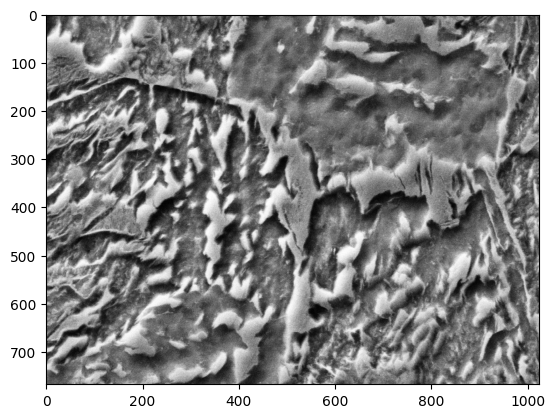

In [27]:
# Testing images were loaded correctly
plt.imshow(train_images[11], cmap=plt.cm.gray)
plt.show()

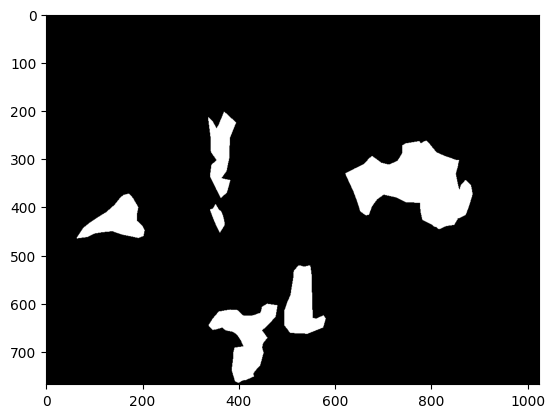

In [28]:
# Testing images were loaded correctly
plt.imshow(train_masks[11], cmap=plt.cm.gray)
plt.show()

In [29]:
test_im = train_masks[11]
test_im = torch.tensor(test_im).unsqueeze(dim=0).unsqueeze(dim=0).float()
test_im.shape

torch.Size([1, 1, 768, 1024])

In [30]:
pred = model(test_im.to(DEVICE))

In [31]:
pred.shape

torch.Size([1, 1, 768, 1024])

In [32]:
mask_pred = torch.sigmoid(pred)
mask_pred = (mask_pred > 0.5).float()

In [33]:
a = Tensor.cpu(pred.squeeze(dim=0).squeeze(dim=0)).detach().numpy()
a

array([[ -9.677879 , -13.2634325, -12.630743 , ..., -12.160387 ,
        -13.168072 ,  -9.533053 ],
       [-12.237394 , -16.39949  , -15.093572 , ..., -14.283597 ,
        -16.146383 , -11.57136  ],
       [-11.653385 , -14.898806 , -13.418482 , ..., -11.949499 ,
        -14.54932  , -10.817986 ],
       ...,
       [-11.106622 , -15.129443 , -14.128199 , ..., -12.704608 ,
        -14.845356 , -11.369059 ],
       [-11.993116 , -16.570911 , -15.843894 , ..., -15.318129 ,
        -16.795898 , -12.305703 ],
       [ -9.17664  , -11.94701  , -11.523426 , ..., -11.583156 ,
        -12.417334 ,  -9.572373 ]], dtype=float32)

In [34]:
b = Tensor.cpu(mask_pred.squeeze(dim=0).squeeze(dim=0)).detach().numpy()
b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

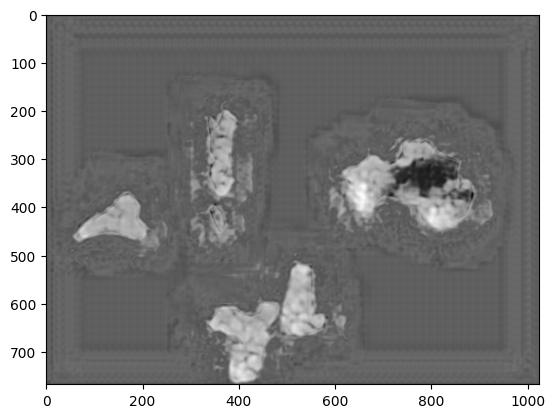

In [35]:
# Visualizing predicted mask
plt.imshow(a, cmap=plt.cm.gray)
plt.show()

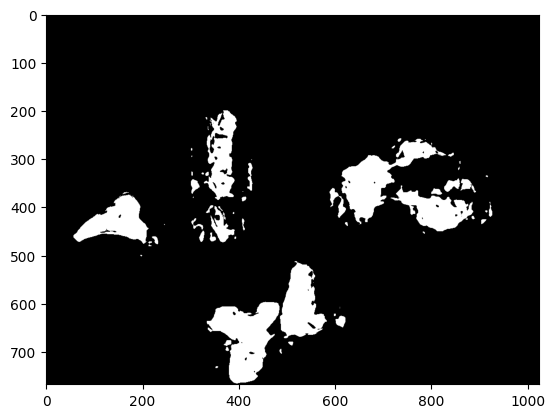

In [36]:
# Visualizing predicted mask
plt.imshow(b, cmap=plt.cm.gray)
plt.show()